# Лабораторная работа 2. Методы классификации и прогнозирования
Выполнил: студент гр. АСМ-18-04, Макаров И.Д.

In [1]:
# Импортируем необходимые библиотеки
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals import joblib

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC

from ipywidgets import IntProgress
from IPython.display import display
import time

C:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [147]:
# Полный вывод датафреймов
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', -1)

### 1.1 Прогнозирование свойства образца дизельного топлива по результатам спектрального анализа

In [2]:
# Импортируем данные
# Файл со свойствами дизельного топлива
prop_file = 'LR2_data/diesel_prop.csv'
# Файл с результатами спектрометрии
spec_file = 'LR2_data/diesel_spec.csv'

prop_df = pd.read_csv(prop_file, skiprows=8, encoding='latin_1', usecols=[*range(1,9)])
spec_df = pd.read_csv(spec_file, skiprows=9, encoding='latin_1', usecols=[*range(1,403)])
print(prop_df.info())
print(spec_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 8 columns):
Unnamed: 1    784 non-null int64
BP50          395 non-null float64
CN            381 non-null float64
D4052         395 non-null float64
FLASH         395 non-null float64
FREEZE        395 non-null float64
TOTAL         395 non-null float64
VISC          395 non-null float64
dtypes: float64(7), int64(1)
memory usage: 49.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Columns: 402 entries, Unnamed: 1 to 1550
dtypes: float64(401), int64(1)
memory usage: 2.4 MB
None


Видно, что в первом датафрейме много пропущенных данных

In [3]:
# Переименуем первый столбец (номер образца)
prop_df = prop_df.rename(columns={'Unnamed: 1': 'N_sample'})
spec_df = spec_df.rename(columns={'Unnamed: 1': 'N_sample'})

In [4]:
# Посмотрим статистику по свойствам дизельного топлива
prop_df.describe()

,N_sample,BP50,CN,D4052,FLASH,FREEZE,TOTAL,VISC
count,784.000000,395.000000,381.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,22080.820153,258.372152,49.160367,0.844568,62.425316,-14.005063,30.745823,2.516911
std,997.125768,20.720664,3.520441,0.015425,8.647723,11.683905,6.758961,0.528419
min,17366.000000,182.000000,36.900000,0.781800,23.000000,-59.500000,8.300000,1.120000
25%,21062.750000,252.000000,47.000000,0.839500,59.000000,-14.450000,27.100000,2.275000
50%,21826.500000,264.000000,48.900000,0.848000,63.000000,-10.300000,32.200000,2.580000
75%,22812.250000,271.000000,50.900000,0.854200,67.000000,-8.400000,35.750000,2.835000
max,24384.000000,297.000000,61.300000,0.872800,96.000000,6.600000,47.200000,4.050000


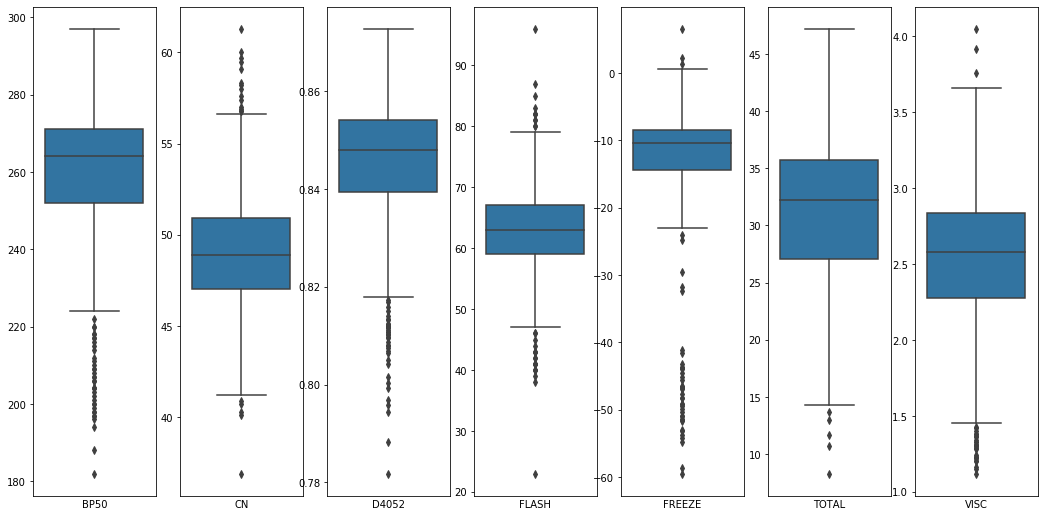

In [6]:
# Более наглядно: построим боксплоты. Теперь выбросы хорошо видны
plt.figure(figsize=(18, 9))
cols = prop_df.drop(['N_sample'], axis=1).columns

l = len(cols)
for i in range(l):
    plt.subplot(1,7,i+1)
    sns.boxplot(data=prop_df[cols[i]])
    plt.xlabel(cols[i])
    plt.xticks(())

Для всех свойств топлива характерны выбросы, но значения не единичны и не отличаются на порядок(-ки).
Следовательно, это может говорить о новых значениях, полученных в результате анализа топлива, а не об ошибках измерения.

In [19]:
# Заполним пропуски в данных методом интерполяции
prep_prop_df = prop_df.interpolate(limit_direction='both')

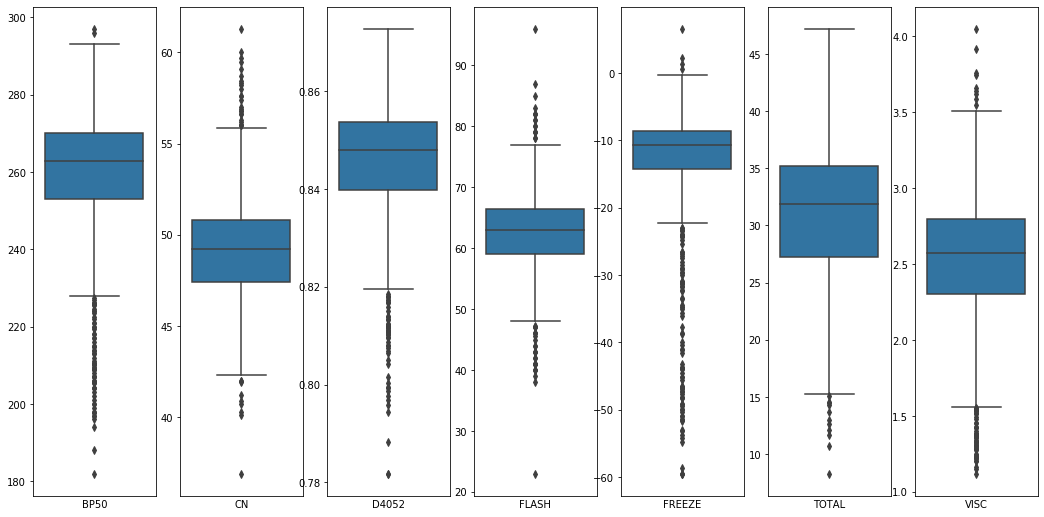

In [16]:
# Построим боксплоты снова. Добавилось ещё немного выбросов...
plt.figure(figsize=(18, 9))
cols = prep_prop_df.drop(['N_sample'], axis=1).columns

l = len(cols)
for i in range(l):
    plt.subplot(1,l,i+1)
    sns.boxplot(data=prep_prop_df[cols[i]])
    plt.xlabel(cols[i])
    plt.xticks(())

In [11]:
# Добавим функцию для удаления выбросов
def outliers_treatment(df):
    str1 = '0%'
    cols = df.describe().columns
    prgBar = IntProgress(min = 1, max = len(cols), description=str1)
    display(prgBar)
    
    for i in cols:
        Q1 = df.describe().at['25%', i]
        Q3 = df.describe().at['75%', i]
        IQR = Q3 - Q1
        LTV = Q1 - 1.5*IQR
        UTV = Q3 + 1.5*IQR
        x = np.array(df[i])
        p = [df[i].median() if (j < LTV or j > UTV) else j for j in x]

        df[i] = p
        
        prgBar.value = prgBar.value + 1
        prgBar.description = str('{:.1f}%'.format(prgBar.value*100/len(cols)))
        time.sleep(0.1)

    return df

In [17]:
# Подчистим выбросы в целевом датасете
prep_prop_df2 = outliers_treatment(prep_prop_df)

IntProgress(value=1, description='0%', max=8, min=1)

Посмотрим, как скажется удаление выбросов на качестве первичной модели.

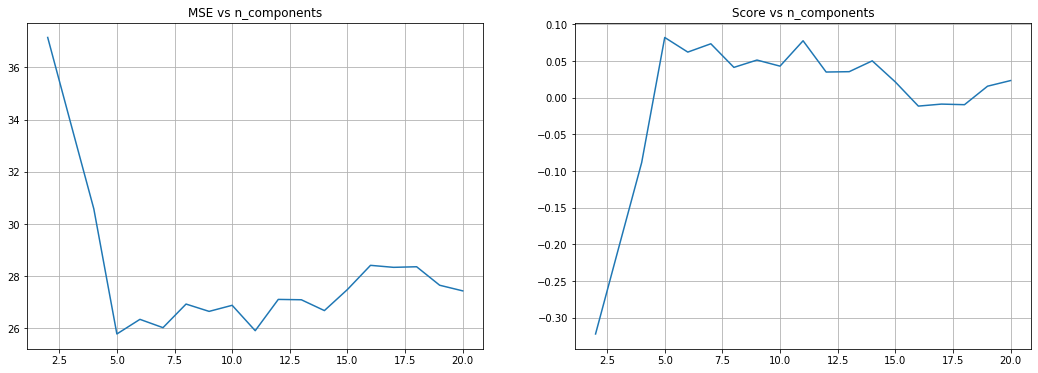

In [14]:
# Понизим размерность обучающих признаков
# Для этого используем "случайный лес" и метод главных компонент
# Разделим целевое множество на обучающее и валидационное подмножества
Y_train = prep_prop_df2.drop(['N_sample'], axis=1).iloc[:627,:]
Y_test = prep_prop_df2.drop(['N_sample'], axis=1).iloc[628:,:]

# Инициализируем регрессор - "случайный лес"
rf = RandomForestRegressor(n_estimators=10, random_state=5)

MSE = []
score = []
rng = range(2,21)
for i in rng:
    pca = PCA(n_components = i)
    XPCAreduced = pca.fit_transform(spec_df.drop(['N_sample'], axis=1))

    X_train = XPCAreduced[:627]
    X_test = XPCAreduced[628:]
    
    rf.fit(X_train, Y_train)
    rf_predict = rf.predict(X_test)

    MSE.append(metrics.mean_squared_error(Y_test, rf_predict))
    score.append(rf.score(X_test, Y_test))
    
# Построим графики зависимости средней квадратичной ошибки регрессии от числа компонент
# и качества модели от числа компонент
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(rng, MSE)
plt.title('MSE vs n_components')
plt.grid(True)
plt.subplot(122)
plt.plot(rng, score)
plt.title('Score vs n_components')
plt.grid(True)

Получилось, как получилось. Посмотрим теперь без процедуры удаления выбросов и сравним результаты.

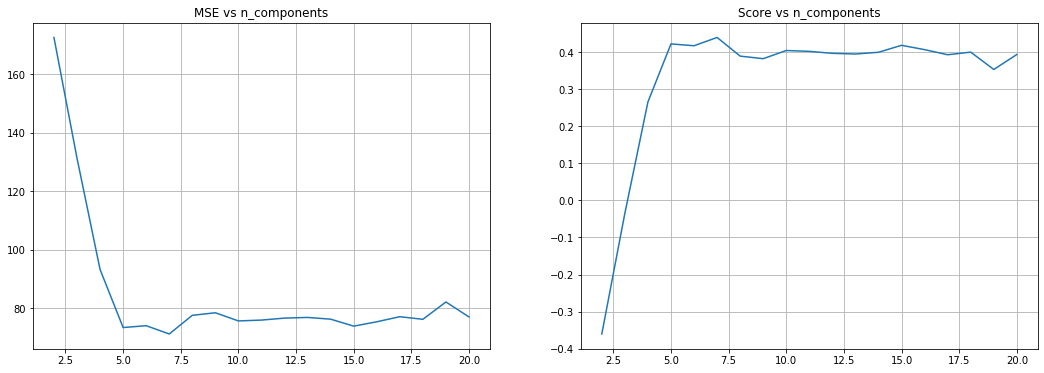

In [20]:
# Понизим размерность обучающих признаков
# Для этого используем "случайный лес" и метод главных компонент
# Разделим целевое множество на обучающее и валидационное подмножества
Y_train = prep_prop_df.drop(['N_sample'], axis=1).iloc[:627,:]
Y_test = prep_prop_df.drop(['N_sample'], axis=1).iloc[628:,:]

# Инициализируем регрессор - "случайный лес"
rf = RandomForestRegressor(n_estimators=10, random_state=5)

MSE = []
score = []
rng = range(2,21)
for i in rng:
    pca = PCA(n_components = i)
    XPCAreduced = pca.fit_transform(spec_df.drop(['N_sample'], axis=1))

    X_train = XPCAreduced[:627]
    X_test = XPCAreduced[628:]
    
    rf.fit(X_train, Y_train)
    rf_predict = rf.predict(X_test)

    MSE.append(metrics.mean_squared_error(Y_test, rf_predict))
    score.append(rf.score(X_test, Y_test))
    
# Построим графики зависимости средней квадратичной ошибки регрессии от числа компонент
# и качества модели от числа компонент
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(rng, MSE)
plt.title('MSE vs n_components')
plt.grid(True)
plt.subplot(122)
plt.plot(rng, score)
plt.title('Score vs n_components')
plt.grid(True)

Из графика зависимости качества модели видно, что качество улучшилось с 0.1 до 0.4, поэтому оставим датасет с выбросами.
Также видно, что оптимальное число компонент - 7.

In [94]:
# Понизим размерность данных методом главных компонент
pca = PCA(n_components = 7)
XPCAreduced = pca.fit_transform(spec_df.drop(['N_sample'], axis=1))

# Покажем долю дисперсии для каждой компоненты
print('Explained variance ratio:\n')
for item in pca.explained_variance_ratio_:
    print('| {:.3f} |'.format(item))

Explained variance ratio:

| 0.696 |
| 0.200 |
| 0.068 |
| 0.022 |
| 0.006 |
| 0.003 |
| 0.002 |


In [51]:
# Разделим множества регрессоров и целевых признаков на тренировочное и тестовое подмножества
X_data = pd.DataFrame(data=XPCAreduced)

Y_data = prep_prop_df.drop(['N_sample'], axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=7)

Model has not been found! Training begins...


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters:  {'n_estimators': 100} 
R2 score:  0.2954843358195544


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters:  {'max_depth': 15} 
R2 score:  0.2900148995246133


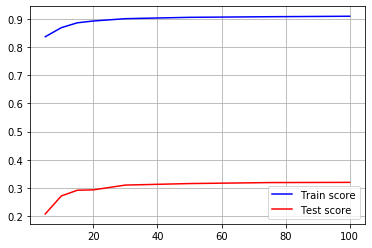

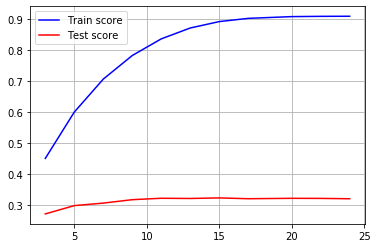

In [70]:
# Первая модель регрессии - случайный лес (метод бэггинга)
filename = 'dump/diesel/RandomForestRegressor.joblib.pkl'
try:
    rfr = joblib.load(filename)
    b = True
    print('Model has been found!')
    print(rfr)
except:
    b = False
    print('Model has not been found! Training begins...')

if not b:
    # Инициализируем нашу модель
    rf = RandomForestRegressor(random_state=5, n_jobs=-1)

    # Зададим набор значений числа базовых моделей n_estimators
    rng = [5, 10, 15, 20, 30, 50, 75, 100]
    forest_params = {'n_estimators': rng}
    
    # Инициализируем и проведём кросс-валидацию
    forest_grid = GridSearchCV(rf, forest_params, cv=10, n_jobs=-1, return_train_score=True)
    forest_grid.fit(X_train, Y_train)

    # Выведем результаты обучения и тестирования
    train_score = forest_grid.cv_results_['mean_train_score']
    test_score = forest_grid.cv_results_['mean_test_score']
    x = rng

    plt.figure()
    plt.plot(x, train_score, "b", label='Train score')
    plt.plot(x, test_score, "r", label='Test score')
    ttl = 'Train and test scores vs n_esimators'
    plt.title(ttl)
    plt.legend()
    plt.grid(True)

    print('Best parameters: ', forest_grid.best_params_,
          '\nR2 score: ', metrics.r2_score(Y_test, forest_grid.predict(X_test)))
    n_estimators_ = forest_grid.best_params_['n_estimators']

    # Повторим эксперимент, зафиксируем число базовых моделей n_estimators
    # и зададим значения глубины дерева max_depth
    rf = RandomForestRegressor(n_estimators=n_estimators_, random_state=5)
    rng = rng = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
    forest_params = {'max_depth': rng}
    forest_grid = GridSearchCV(rf, forest_params, cv=10, n_jobs=-1, return_train_score=True)
    forest_grid.fit(X_train, Y_train)
    
    # Сохраняем в файл
    rfr = forest_grid.best_estimator_
    _ = joblib.dump(rfr, filename)

    # Выведем результаты обучения и тестирования
    train_score = forest_grid.cv_results_['mean_train_score']
    test_score = forest_grid.cv_results_['mean_test_score']
    x = rng

    plt.figure()
    plt.plot(x, train_score, "b", label='Train score')
    plt.plot(x, test_score, "r", label='Test score')
    ttl = 'Train and test scores vs max_depth, n_esimators='+ str(n_estimators_)
    plt.title(ttl)
    plt.legend()
    plt.grid(True)

    print('Best parameters: ', forest_grid.best_params_,
          '\nR2 score: ', metrics.r2_score(Y_test, forest_grid.predict(X_test)))
    
# Оценим качество полученной модели:
rfr_quality = [metrics.mean_squared_error(Y_test, rfr.predict(X_test)),
               metrics.mean_absolute_error(Y_test, rfr.predict(X_test)),
               metrics.r2_score(Y_test, rfr.predict(X_test))]

На первом графике качество модели на тренировочной выборке достигло 1, что говорит о переобучении.
Глубина дерева - хороший регуляризирующий параметр для "случайного леса", о чём можно судить по второму графику.

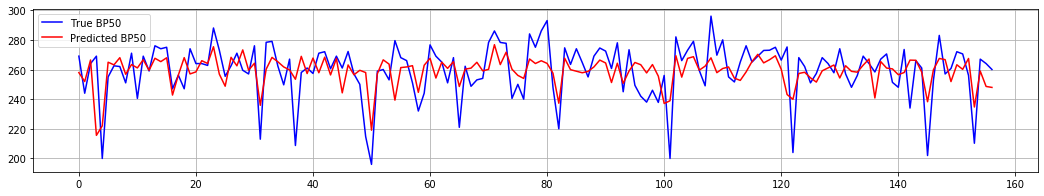

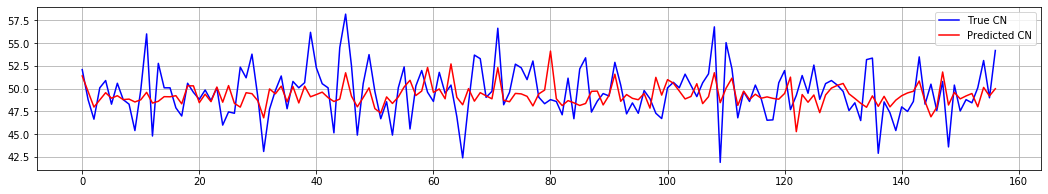

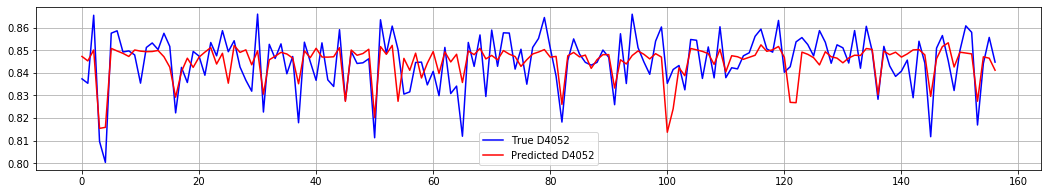

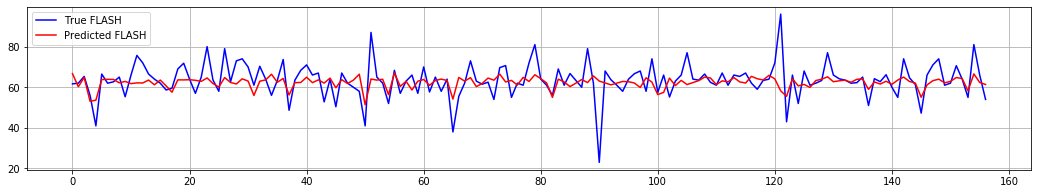

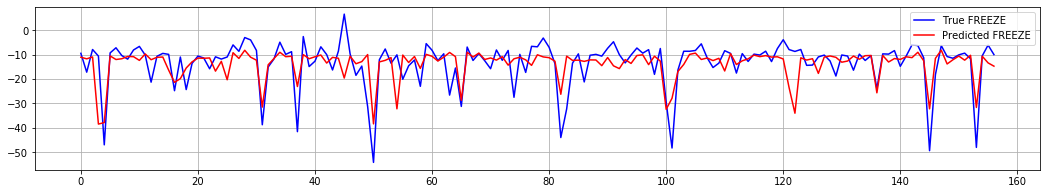

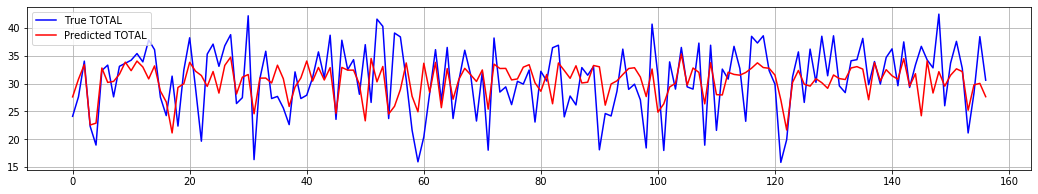

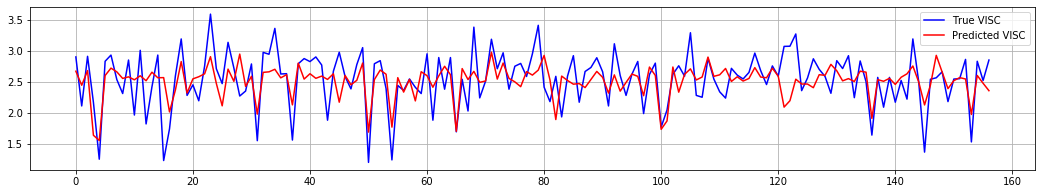

In [75]:
# Построим график истинных значений и прогнозных
y_pred = rfr.predict(X_test)
x = range(len(y_pred))

cols = Y_test.columns
for i in range(len(cols)):
    plt.figure(figsize=(18, 3))
    lbl1 = 'True '+ cols[i]
    lbl2 = 'Predicted '+ cols[i]
    plt.plot(x, Y_test[cols[i]], "b", label=lbl1)
    plt.plot(x, y_pred[:,i], "r", label=lbl2)
    plt.legend()
    plt.grid(True)

Визуально качество модели удовлетворительно: есть правильно отработанные значения, есть отработки в противоположную сторону.

In [72]:
# Посчитаем коэффициенты корреляции Пирсона для каждого свойства ДТ
corr_coef = []
l = len(Y_test.values[0])
for i in range(l):
    corr_coef.append(np.corrcoef(Y_test.values[:,i], y_pred[:,i])[0,1])
    
corr_coef

[0.5893491028483253,
 0.3615696048111076,
 0.6554859671329168,
 0.4460966473456831,
 0.6243932007782467,
 0.4878058060136191,
 0.6035361506112222]

Как видим, и статистически качество модели удовлетворительно: коэффициенты корреляции примерно на одном уровне, но недостаточно близки к единице.

Model has not been found! Training begins...


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters:  {'knn__n_neighbors': 8} 
R2 score:  0.20799047289887812


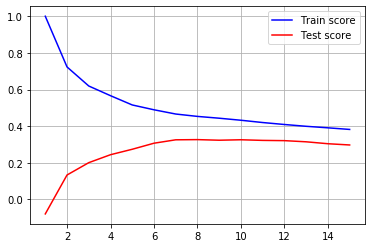

In [82]:
# Вторая модель регрессии - k-ближайших соседей
filename = 'dump/diesel/KNeighborsRegressor.joblib.pkl'
try:
    knn = joblib.load(filename)
    b = True
    print('Model has been found!')
    print(knn)
except:
    b = False
    print('Model has not been found! Training begins...')

if not b:
    # Инициализируем нашу модель
    knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_jobs=-1))])
    
    # Зададим набор значений числа ближайших соседей knn__n_neighbors
    rng = range(1,16)
    knn_params = {'knn__n_neighbors': rng}
    
    # Инициализируем и проведём кросс-валидацию
    knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, return_train_score=True)
    knn_grid.fit(X_train, Y_train)

    # Сохраняем в файл
    knn = knn_grid.best_estimator_
    _ = joblib.dump(knn, filename)

    # Выведем результаты обучения и тестирования
    train_score = knn_grid.cv_results_['mean_train_score']
    test_score = knn_grid.cv_results_['mean_test_score']
    x = rng

    plt.figure()
    plt.plot(x, train_score, "b", label='Train score')
    plt.plot(x, test_score, "r", label='Test score')
    plt.legend()
    plt.grid(True)


    print('Best parameters: ', knn_grid.best_params_,
          '\nR2 score: ', metrics.r2_score(Y_test, knn.predict(X_test)))

# Оценим качество полученной модели:
knn_quality = [metrics.mean_squared_error(Y_test, knn.predict(X_test)),
               metrics.mean_absolute_error(Y_test, knn.predict(X_test)),
               metrics.r2_score(Y_test, knn.predict(X_test))]

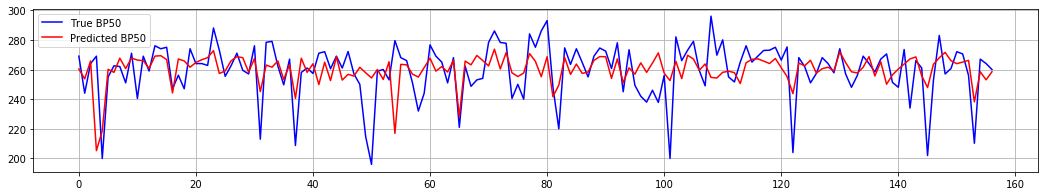

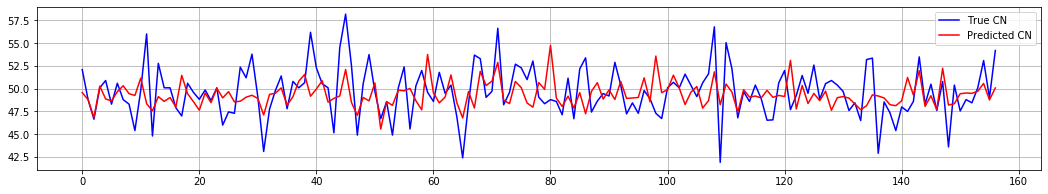

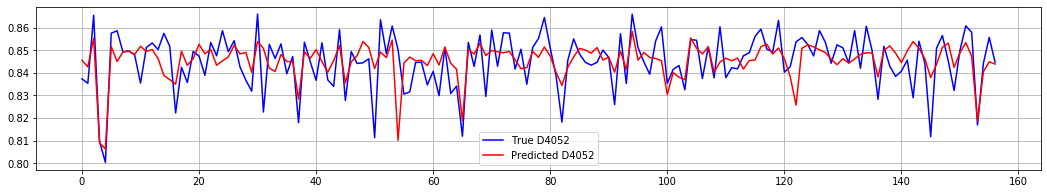

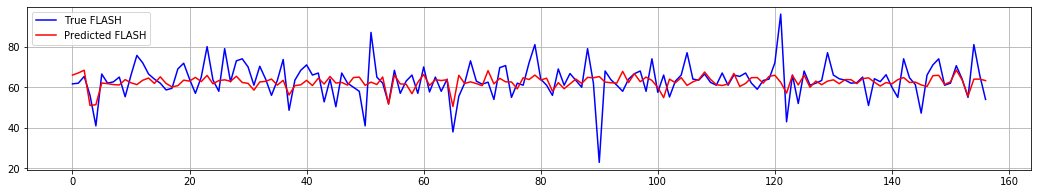

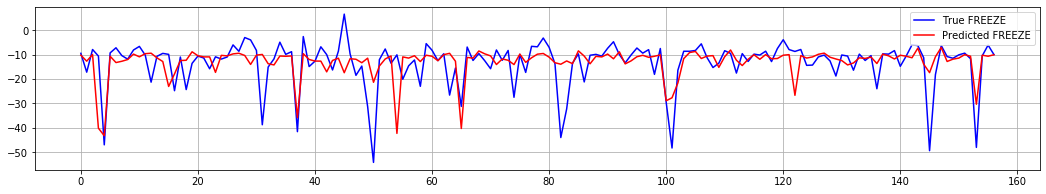

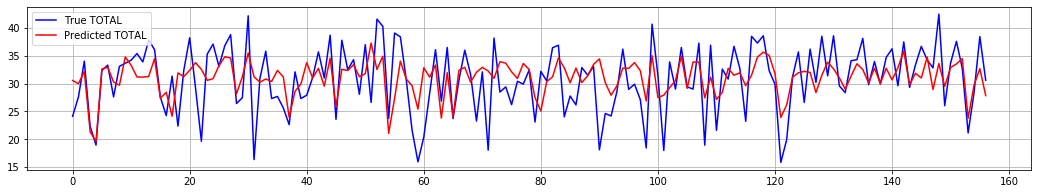

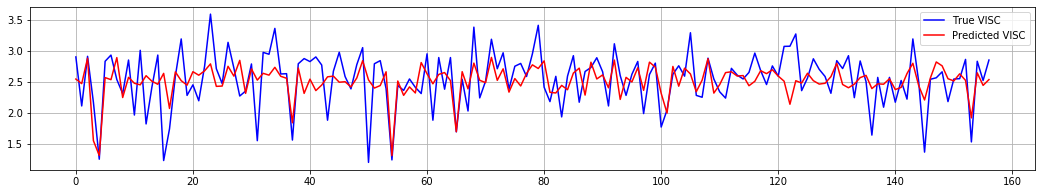

In [83]:
# Построим график истинных значений и прогнозных
y_pred = knn.predict(X_test)
x = range(len(y_pred))

cols = Y_test.columns
for i in range(len(cols)):
    plt.figure(figsize=(18, 3))
    lbl1 = 'True '+ cols[i]
    lbl2 = 'Predicted '+ cols[i]
    plt.plot(x, Y_test[cols[i]], "b", label=lbl1)
    plt.plot(x, y_pred[:,i], "r", label=lbl2)
    plt.legend()
    plt.grid(True)

Визуально качество модели удовлетворительно: есть правильно отработанные значения, есть отработки в противоположную сторону. Однако всё же видно, что качество хуже, чем для "случайного леса".

In [84]:
# Посчитаем коэффициенты корреляции Пирсона для каждого свойства ДТ
corr_coef = []
l = len(Y_test.values[0])
for i in range(l):
    corr_coef.append(np.corrcoef(Y_test.values[:,i], y_pred[:,i])[0,1])
    
corr_coef

[0.43543623432129214,
 0.29667577817523355,
 0.5987788793655924,
 0.34565818946402926,
 0.48662244928829157,
 0.5317790754192266,
 0.535358856551258]

Статистически данная модель также хуже "случайного леса"

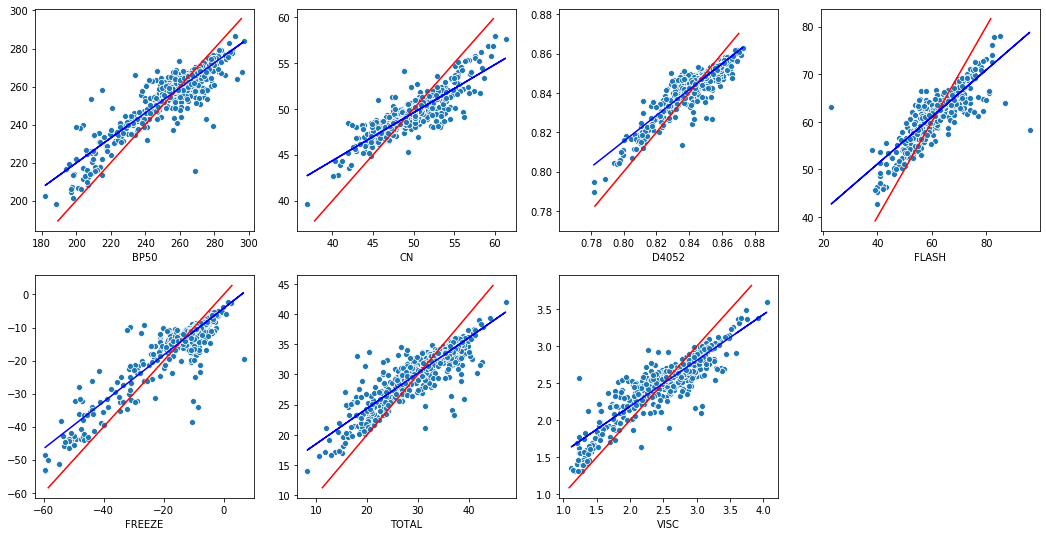

In [93]:
# Построим графики, на оси абсцисс которых расположены истинные значения, а на оси ординат - прогнозные
plt.figure(figsize=(18, 9))
cols = Y_data.columns
y_pred = rfr.predict(X_data)
lin = LinearRegression()

l = len(cols)
for i in range(l):
    plt.subplot(2,4,i+1)
    sns.scatterplot(x=Y_data[cols[i]], y=y_pred[:,i])
    lim1 = min(y_pred[:,i])
    lim2 = max(y_pred[:,i])
    ran = lim2 - lim1
    plt.plot([lim1-0.1*ran, lim2+0.1*ran], [lim1-0.1*ran, lim2+0.1*ran], 'r-')
    
    X = np.asarray(Y_data[cols[i]]).reshape(-1,1)
    Y = y_pred[:,i].reshape(-1,1)
    lin.fit(X, Y)
    fact = lin.predict(X)
    plt.plot(Y_data[cols[i]], fact, 'b-')

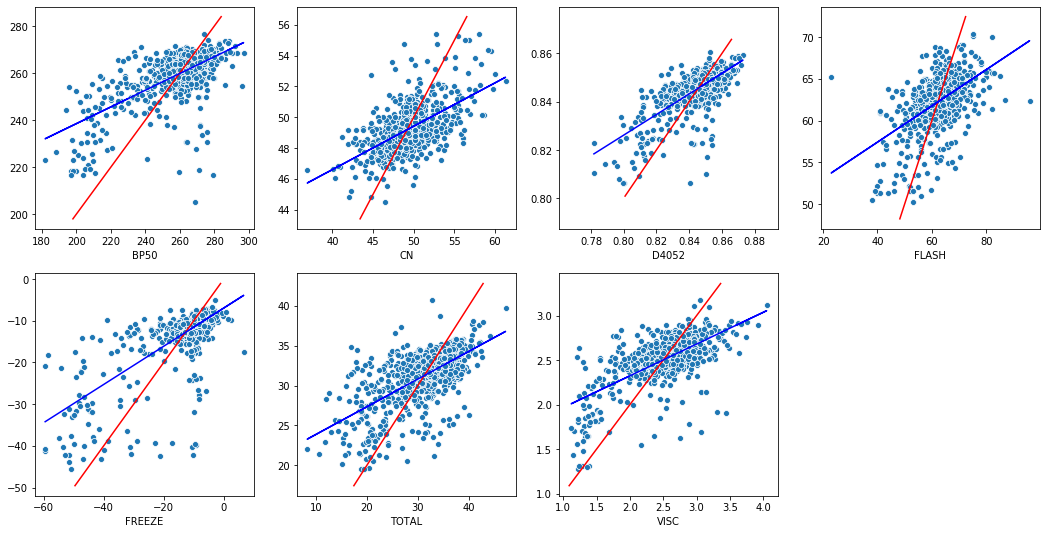

In [94]:
plt.figure(figsize=(18, 9))
cols = Y_data.columns
y_pred = knn.predict(X_data)

l = len(cols)
for i in range(l):
    plt.subplot(2,4,i+1)
    sns.scatterplot(x=Y_data[cols[i]], y=y_pred[:,i])
    lim1 = min(y_pred[:,i])
    lim2 = max(y_pred[:,i])
    ran = lim2 - lim1
    plt.plot([lim1-0.1*ran, lim2+0.1*ran], [lim1-0.1*ran, lim2+0.1*ran], 'r-')
    
    X = np.asarray(Y_data[cols[i]]).reshape(-1,1)
    Y = y_pred[:,i].reshape(-1,1)
    lin.fit(X, Y)
    fact = lin.predict(X)
    plt.plot(Y_data[cols[i]], fact, 'b-')

Из построенных графиков очевидна разница в качестве модели "случайный лес" перед К-ближайших соседей: значения модели "случайный лес" ложатся ближе к линии полного совпадения.

In [95]:
print('Random Forest Regressor MSE: %.3f' % rfr_quality[0],
      '\nRandom Forest Regressor MAE: %.3f' %  rfr_quality[1],
      '\nRandom Forest Regressor R2-score: %.3f' % rfr_quality[2],
      '\n\nKNeighborsRegressor MSE: %.3f' %  knn_quality[0],
      '\nKNeighborsRegressor MAE: %.3f' % knn_quality[1],
      '\nKNeighborsRegressor R2-score: %.3f' %  knn_quality[2])

Random Forest Regressor MSE: 53.662 
Random Forest Regressor MAE: 4.040 
Random Forest Regressor R2-score: 0.290 

KNeighborsRegressor MSE: 64.286 
KNeighborsRegressor MAE: 4.101 
KNeighborsRegressor R2-score: 0.208


### 1.2 Идентификация контрафактной продукции по результатам спектроскопии образцов лекарственного препарата

In [144]:
# Так как целевых класса только два, то имеем задачу бинарной классификации.
# Импортируем данные
medicine_file = 'LR2_data/Metronidazole.xls'

med_df = pd.read_excel(medicine_file, sheet_name='Metronidazole_Data')
med_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Columns: 110 entries, Unnamed: 0 to G28-5
dtypes: float64(109), int64(1)
memory usage: 2.6 MB


In [145]:
med_df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [151]:
# Транспонируем датафрейм для приведения данных к виду n_samples : n_features
# Здесь n_samples - образцы лекарства, n_features - результаты спектрального анализа
med_df = med_df.T

In [6]:
# Понизим размерность данных методом главных компонент
pca = PCA(n_components = 6)
med_df_reduced = pca.fit_transform(med_df)
med_df_reduced = pd.DataFrame(data=med_df_reduced, index=med_df.index)

# Покажем долю дисперсии для каждой компоненты
print('Explained variance ratio:\n')
for item in pca.explained_variance_ratio_:
    print('| {:.3f} |'.format(item))

Explained variance ratio:

| 0.867 |
| 0.108 |
| 0.013 |
| 0.008 |
| 0.003 |
| 0.001 |


In [8]:
# Введём целевой столбец: подделку обозначим "1", оригинал - "0"
target = [1 if r'F' in idx else 0 for idx in med_df.index]
med_df_reduced['target'] = target

In [76]:
# Разделим данные на множество описаний образцов X_cl и множество классов Y_cl
X_cl = med_df_reduced.drop(['target'], axis=1)
Y_cl = med_df_reduced['target']

# Разделим полученные множества на тренировочное и тестовое подмножества
train_index = list(range(2,90))
test_index = list(set(range(len(Y_cl)))-set(train_index))
X_train, X_test, Y_train, Y_test = X_cl.iloc[train_index, :], X_cl.iloc[test_index, :], Y_cl[train_index], Y_cl[test_index]

Model not found! Training begins...
{'C': 0.5499999999999999}


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


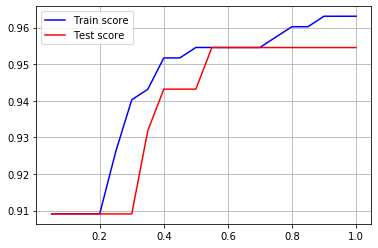

In [136]:
# Первый классификатор - классификатор на опорные вектора
filename = 'dump/medicine/SupportVectorClassifier.joblib.pkl'
try:
    svc = joblib.load(filename)
    b = True
    print('Model has been found!')
    print(svc)
except:
    b = False
    print('Model has not been found! Training begins...')

if not b:
    # Инициализируем страифицированную разбивку нашего датасета для валидации
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
    
    # Инициализируем наш классификатор с дефолтными параметрами
    svc = LinearSVC(random_state=5)
    # Зададим набор значений параметра С, который отвечает за регуляризацию
    rng = np.linspace(0.05,1,num=20)
    svc_params = {'C': rng}
    # Инициализируем и проведём кросс-валидацию
    svc_grid = GridSearchCV(svc, svc_params, cv=skf, n_jobs=-1, return_train_score=True)
    svc_grid.fit(X_train, Y_train)

    # Сохраняем в файл
    svc = svc_grid.best_estimator_
    _ = joblib.dump(svc, filename)
    
    # Выведем результаты обучения и тестирования
    train_score = svc_grid.cv_results_['mean_train_score']
    test_score = svc_grid.cv_results_['mean_test_score']
    x = rng
    
    plt.plot(x, train_score, "b", label='Train score')
    plt.plot(x, test_score, "r", label='Test score')
    plt.legend()
    plt.grid(True)
    
    print(svc_grid.best_params_)

# Оценим качество полученной модели:
svc_accuracy = metrics.accuracy_score(Y_test, svc.predict(X_test))
svc_precision = metrics.precision_score(Y_test, svc.predict(X_test))
svc_recall = metrics.recall_score(Y_test, svc.predict(X_test))

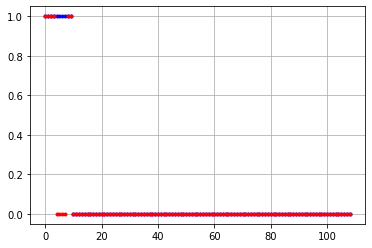

In [134]:
# Визуализируем результаты классификации для всех исходных данных
x = range(len(Y_cl))
plt.plot(x, Y_cl, "b.")
plt.plot(x, svc.predict(X_cl), "r.")
plt.grid(True)

Как видно из графика, часть тренировочных данных была неправильно классифицирована, а именно, здесь мы видим ошибку 2 рода, т.е. часть образцов-подделок была классифицирована как оригинал.

Model not found! Training begins...


<Figure size 432x288 with 0 Axes>

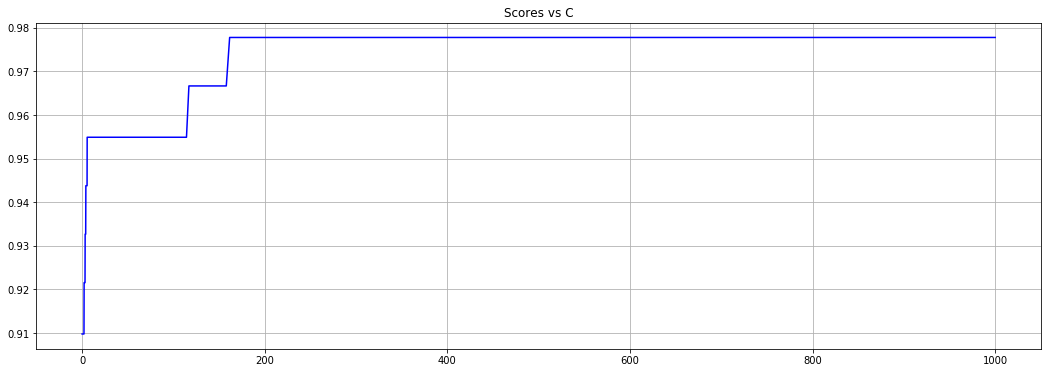

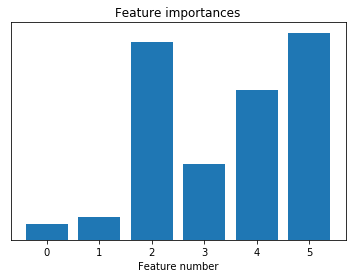

In [138]:
# Второй классификатор - логистическая регрессия
filename = 'dump/medicine/LogisticRegression.joblib.pkl'
try:
    logreg = joblib.load(filename)
    b = True
    print('Model has been found!')
    print(logreg)
except:
    b = False
    print('Model has not been found! Training begins...')

if not b:
    # Инициализируем страифицированную разбивку нашего датасета для валидации
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

    # Зададим набор значений параметра С, который отвечает за регуляризацию,
    # при этом сила регуляризации обратно пропорциональна параметру С
    c_values = np.logspace(-2, 3, 500)

    # Инициализируем и проведём кросс-валидацию
    logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, n_jobs=-1)
    logit_searcher.fit(X_train, Y_train)
    
    # Сохраняем в файл
    logreg = logit_searcher
    _ = joblib.dump(logreg, filename)
    
    # Посмотрим, как качество модели (доля правильных ответов на обучающей и валидационной выборках)
    # меняется при изменении гиперпараметра С.
    plt.figure()
    _, v = logit_searcher.scores_.popitem()
    scores = np.mean(v, axis=0)
    plt.figure(figsize=(18, 6))
    plt.plot(c_values, scores, "b")
    plt.title('Scores vs C')
    plt.grid(True)
    
    # Построим диаграмму весов признаков для данной модели
    plt.figure()
    svm_weights = np.abs(logit_searcher.coef_[0])
    svm_weights /= svm_weights.sum()
    plt.bar(X_cl.columns, svm_weights)
    plt.xlabel('Feature number')
    plt.yticks(())
    plt.axis('tight')
    plt.title('Feature importances')
    plt.show()

# Оценим качество полученной модели:
log_accuracy = metrics.accuracy_score(Y_test, logit_searcher.predict(X_test)) 
log_precision = metrics.precision_score(Y_test, logit_searcher.predict(X_test))
log_recall = metrics.recall_score(Y_test, logit_searcher.predict(X_test))

Из графика зависимости качества модели от параметра *С* видно, что лучшее качество модели получается при слабой регуляризации. По столбчатой диаграмме видно, что 5я и 2я компонента сильнее всего влияют на модель.

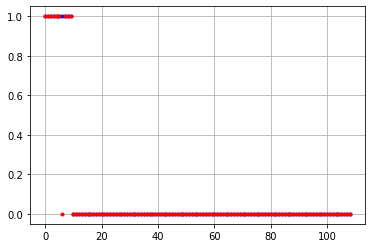

In [27]:
# Визуализируем результаты классификации для всех исходных данных
x = range(len(Y_cl))
plt.plot(x, Y_cl, "b.")
plt.plot(x, logit_searcher.predict(X_cl), "r.")
plt.grid(True)

Как видно из графика, один образец был неправильно идентифицирован, здесь также ошибка 2 рода, т.е. часть образцов-подделок была классифицирована как оригинал.

Model not found! Training begins...


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 5}


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 7}


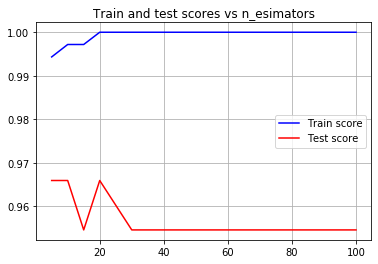

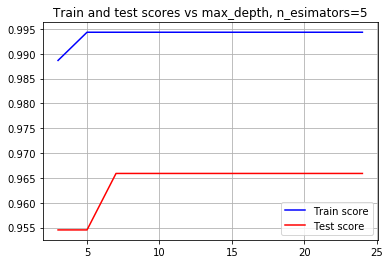

In [140]:
# Третий классификатор - случайный лес (метод бэггинга)
filename = 'dump/medicine/RandomForestClassifier.joblib.pkl'
try:
    rfc = joblib.load(filename)
    b = True
    print('Model has been found!')
    print(rfc)
except:
    b = False
    print('Model has not been found! Training begins...')

if not b:
    # Инициализируем страифицированную разбивку нашего датасета для валидации
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

    # Инициализируем наш классификатор
    rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
    
    # Зададим набор значений числа базовых моделей n_estimators
    rng = [5, 10, 15, 20, 30, 50, 75, 100]
    rfc_params = {'n_estimators': rng}
    
    # Инициализируем и проведём кросс-валидацию
    rfc_grid = GridSearchCV(rfc, rfc_params, cv=skf, n_jobs=-1, return_train_score=True)
    rfc_grid.fit(X_train, Y_train)
    
    # Выведем результаты обучения и тестирования
    train_score = rfc_grid.cv_results_['mean_train_score']
    test_score = rfc_grid.cv_results_['mean_test_score']
    x = rng
    
    plt.figure()
    plt.plot(x, train_score, "b", label='Train score')
    plt.plot(x, test_score, "r", label='Test score')
    plt.legend()
    plt.title('Train and test scores vs n_esimators')
    plt.grid(True)
    
    print(rfc_grid.best_params_)
    n_estimators_ = rfc_grid.best_params_['n_estimators']
    
    # Повторим эксперимент, зафиксируем число базовых моделей n_estimators
    # и зададим значения глубины дерева max_depth
    rfc = RandomForestClassifier(n_estimators=n_estimators_, random_state=42, n_jobs=-1, oob_score=True)
    rng = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
    rfc_params = {'max_depth': rng}
    rfc_grid = GridSearchCV(rfc, rfc_params, cv=skf, n_jobs=-1, return_train_score=True)
    rfc_grid.fit(X_train, Y_train)
    
    # Сохраняем в файл
    rfc = rfc_grid.best_estimator_
    _ = joblib.dump(rfc, filename)
    
    # Выведем результаты обучения и тестирования
    train_score = rfc_grid.cv_results_['mean_train_score']
    test_score = rfc_grid.cv_results_['mean_test_score']
    x = rng
    
    plt.figure()
    plt.plot(x, train_score, "b", label='Train score')
    plt.plot(x, test_score, "r", label='Test score')
    plt.legend()
    ttl = 'Train and test scores vs max_depth, n_esimators='+ str(n_estimators_)
    plt.title(ttl)
    plt.grid(True)
    
    print(rfc_grid.best_params_)
    
# Оценим качество полученной модели:
rfc_accuracy = metrics.accuracy_score(Y_test, rfc.predict(X_test)) 
rfc_precision = metrics.precision_score(Y_test, rfc.predict(X_test))
rfc_recall = metrics.recall_score(Y_test, rfc.predict(X_test))

На первом графике качество модели на тренировочной выборке достигло 1, что говорит о переобучении.
Глубина дерева - хороший регуляризирующий параметр для "случайного леса", о чём можно судить по второму графику.

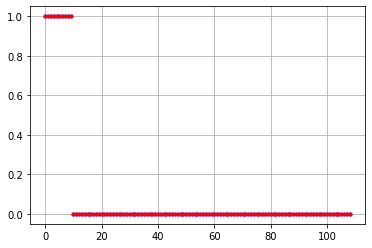

In [132]:
# Визуализируем результаты классификации для всех исходных данных
x = range(len(Y_cl))
plt.plot(x, Y_cl, "b.")
plt.plot(x, rfc.predict(X_cl), "r.")
plt.grid(True)

Похоже, что все образцы идентифицированы верно.

In [141]:
print('Support Vector Classifier accuracy: %.3f' % svc_accuracy,
      '\nRandom Forest Classifier accuracy: %.3f' % rfc_accuracy,
      '\nLogistic Regression accuracy: %.3f' %  log_accuracy,
      '\n\nSupport Vector Classifier precision score: %.3f' % svc_precision,
      '\nRandom Forest Classifier precision score: %.3f' % rfc_precision,
      '\nLogistic Regression precision score: %.3f' % log_precision,
      '\n\nSupport Vector Classifier recall score: %.3f' % svc_recall,
      '\nRandom Forest Classifier recall score: %.3f' % rfc_recall,
      '\nLogistic Regression recall score: %.3f' % log_recall)

Support Vector Classifier accuracy: 1.000 
Random Forest Classifier accuracy: 1.000 
Logistic Regression accuracy: 1.000 

Support Vector Classifier precision score: 1.000 
Random Forest Classifier precision score: 1.000 
Logistic Regression precision score: 1.000 

Support Vector Classifier recall score: 1.000 
Random Forest Classifier recall score: 1.000 
Logistic Regression recall score: 1.000


С тестовым набором все методы справились на отлично

In [142]:
svc_accuracy = metrics.accuracy_score(Y_cl, svc.predict(X_cl)) 
svc_precision = metrics.precision_score(Y_cl, svc.predict(X_cl))
svc_recall = metrics.recall_score(Y_cl, svc.predict(X_cl))
log_accuracy = metrics.accuracy_score(Y_cl, logit_searcher.predict(X_cl)) 
log_precision = metrics.precision_score(Y_cl, logit_searcher.predict(X_cl))
log_recall = metrics.recall_score(Y_cl, logit_searcher.predict(X_cl))
rfc_accuracy = metrics.accuracy_score(Y_cl, rfc.predict(X_cl)) 
rfc_precision = metrics.precision_score(Y_cl, rfc.predict(X_cl))
rfc_recall = metrics.recall_score(Y_cl, rfc.predict(X_cl))

print('Support Vector Classifier accuracy: %.3f' % svc_accuracy,
      '\nRandom Forest Classifier accuracy: %.3f' % rfc_accuracy,
      '\nLogistic Regression accuracy: %.3f' %  log_accuracy,
      '\n\nSupport Vector Classifier precision score: %.3f' % svc_precision,
      '\nRandom Forest Classifier precision score: %.3f' % rfc_precision,
      '\nLogistic Regression precision score: %.3f' % log_precision,
      '\n\nSupport Vector Classifier recall score: %.3f' % svc_recall,
      '\nRandom Forest Classifier recall score: %.3f' % rfc_recall,
      '\nLogistic Regression recall score: %.3f' % log_recall)

Support Vector Classifier accuracy: 0.963 
Random Forest Classifier accuracy: 1.000 
Logistic Regression accuracy: 0.991 

Support Vector Classifier precision score: 1.000 
Random Forest Classifier precision score: 1.000 
Logistic Regression precision score: 1.000 

Support Vector Classifier recall score: 0.600 
Random Forest Classifier recall score: 1.000 
Logistic Regression recall score: 0.900


Применимо ко всему набору данных, лучше всех справился "случайный лес", рядом - логистическая регрессия с 10% ошибок 2-го рода. На последнем месте - классификация на опорные вектора и 40% ошибок 2-го рода.

### 1.3 Идентификация токсичности вещества на основе данных о присутствии/отсутствии молекулярных маркеров

In [153]:
# Так как целевых класса только два, то имеем задачу бинарной классификации.
# Загрузим исходные данные
toxic_file = 'LR2_data/qsar_oral_toxicity.csv'
toxic_df = pd.read_csv(toxic_file, header=None, sep=None)

In [3]:
toxic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8992 entries, 0 to 8991
Columns: 1025 entries, 0 to 1024
dtypes: int64(1024), object(1)
memory usage: 70.3+ MB


In [154]:
# Обозначим положительные результаты (очень токсичное вещество) "1", отрицательные (нетоксичное вещество) - "0"
toxic_df[1024] = [1 if r'pos' in s else 0 for s in toxic_df[1024].values]

In [155]:
# Разделим множества признаков и классов на тренировочное и тестовое подмножества
X_cl = toxic_df.drop([1024], axis=1)
Y_cl = toxic_df[1024]
X_train, X_test, Y_train, Y_test = train_test_split(X_cl, Y_cl, test_size=0.2, random_state=7)

Model not found! Training begins...
{'C': 0.05}


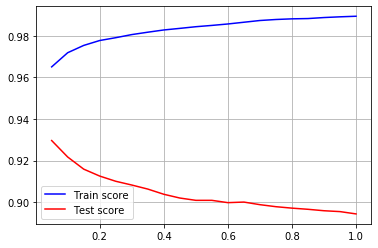

In [156]:
# Первый классификатор - классификатор на опорные вектора
filename = 'dump/toxicity/SupportVectorClassifier.joblib.pkl'
try:
    svc = joblib.load(filename)
    b = True
    print('Model has been found!')
    print(svc)
except:
    b = False
    print('Model has not been found! Training begins...')

if not b:
    # Инициализируем страифицированную разбивку нашего датасета для валидации
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

    # Инициализируем наш классификатор с дефолтными параметрами
    svc = LinearSVC(random_state=5)
    
    # Зададим набор значений параметра С, который отвечает за регуляризацию
    rng = np.linspace(0.05,1,num=20)
    svc_params = {'C': rng}
    
    # Инициализируем и проведём кросс-валидацию
    svc_grid = GridSearchCV(svc, svc_params, cv=skf, n_jobs=-1, return_train_score=True)
    svc_grid.fit(X_train, Y_train)
    
    # Сохраняем в файл
    svc = svc_grid.best_estimator_
    _ = joblib.dump(svc, filename)

    # Выведем результаты обучения и тестирования
    train_score = svc_grid.cv_results_['mean_train_score']
    test_score = svc_grid.cv_results_['mean_test_score']
    x = rng

    plt.plot(x, train_score, "b", label='Train score')
    plt.plot(x, test_score, "r", label='Test score')
    plt.legend()
    plt.grid(True)

    print(svc_grid.best_params_)

# Оценим качество полученной модели:
svc_accuracy = metrics.accuracy_score(Y_test, svc.predict(X_test)) 
svc_precision = metrics.precision_score(Y_test, svc.predict(X_test))
svc_recall = metrics.recall_score(Y_test, svc.predict(X_test))

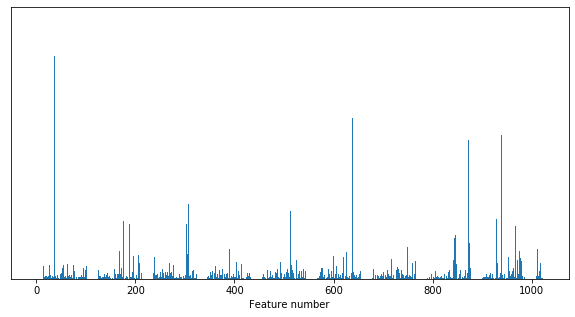

In [157]:
# Выберем признаки в соответствии с самой высокой значимостью, в качестве критерия - Хи-квадрат
# (В итоге мы понизим размерность исходных данных в ~10 раз)
sel= SelectKBest(chi2, k=100)
X_cl_reduced = sel.fit_transform(X_cl, Y_cl)
X_cl_reduced = pd.DataFrame(data=X_cl_reduced)

scores = -np.log10(sel.pvalues_)
scores /= scores.max()

# Построим столбчатую диаграмму по всем признакам
plt.figure(figsize=[10,5])
plt.bar(X_cl.columns, scores)
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.show()

# Сформируем тренировочные и тестовые наборы из датасета с пониженной размерностью
X_train, X_test, Y_train, Y_test = train_test_split(X_cl_reduced, Y_cl, test_size=0.2, random_state=7)

Model not found! Training begins...
{'n_estimators': 80}


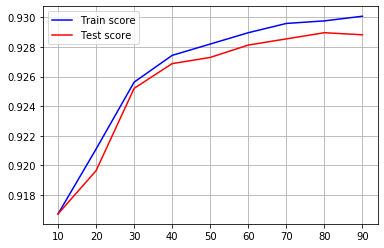

In [159]:
# Второй классификатор - адаптивный бустинг на логистической регрессии
filename = 'dump/toxicity/AdaBoostClassifier.joblib.pkl'
try:
    abc = joblib.load(filename)
    b = True
    print('Model has been found!')
    print(abc)
except:
    b = False
    print('Model has not been found! Training begins...')

if not b:
    # Инициализируем страифицированную разбивку нашего датасета для валидации
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

    # Инициализируем базовый классификатор
    base_cl = LogisticRegression(C=0.6, n_jobs=-1)
    # Инициализируем бустинг-классификатор
    abc = AdaBoostClassifier(base_estimator=base_cl, random_state=7)
    
    # Зададим набор значений числа базовых моделей n_estimators
    rng = range(10,100,10)
    abc_params = {'n_estimators': rng}
    
    # Инициализируем и проведём кросс-валидацию
    abc_grid = GridSearchCV(abc, abc_params, cv=skf, n_jobs=-1, return_train_score=True)
    abc_grid.fit(X_train, Y_train)
    
    # Сохраняем в файл
    abc = abc_grid.best_estimator_
    _ = joblib.dump(abc, filename)
    
    # Выведем результаты обучения и тестирования
    train_score = abc_grid.cv_results_['mean_train_score']
    test_score = abc_grid.cv_results_['mean_test_score']
    x = rng

    plt.plot(x, train_score, "b", label='Train score')
    plt.plot(x, test_score, "r", label='Test score')
    plt.legend()
    plt.grid(True)

    print(abc_grid.best_params_)
    
# Оценим качество полученной модели:
abc_accuracy = metrics.accuracy_score(Y_test, abc.predict(X_test)) 
abc_precision = metrics.precision_score(Y_test, abc.predict(X_test))
abc_recall = metrics.recall_score(Y_test, abc.predict(X_test))

In [160]:
print('Support Vector Classifier accuracy: %.3f' % svc_accuracy,
      '\nAdaptive Boosting Classifier accuracy: %.3f' %  abc_accuracy,
      '\n\nSupport Vector Classifier precision score: %.3f' % svc_precision,
      '\nAdaptive Boosting Classifier precision score: %.3f' %  abc_precision,
      '\n\nSupport Vector Classifier recall score: %.3f' % svc_recall,
      '\nAdaptive Boosting Classifier recall score: %.3f' %  abc_recall)

Support Vector Classifier accuracy: 0.929 
Adaptive Boosting Classifier accuracy: 0.930 

Support Vector Classifier precision score: 0.588 
Adaptive Boosting Classifier precision score: 0.711 

Support Vector Classifier recall score: 0.352 
Adaptive Boosting Classifier recall score: 0.190


Видим, что при одинаковой точности по доле ошибок 1-го рода лучше справилась модель AdaBoost, а по доле ошибок 2-го рода - классификация на опорные вектора. При этом обе модели показали неудовлетворительные результаты по ошибкам 2-го рода.